# Step Tracking Impact

## Task Description:

**Task:**
- Evaluate whether users' physical activity changes after installing the Sweatcoin app.
- The dataset contains daily step count data for a sample of users within a ±2-week range from their registration date.

**Data Description:**
- user_id – unique user ID
- platform – device platform
- reg_date – user registration date
- steps_date – date of recorded steps
- steps – number of steps

**Decomposition of the Task:**
1. Perform data preprocessing
2. Conduct exploratory data analysis (EDA)
3. Compare user activity data before and after app installation
4. Summarize findings, research results, and provide recommendations

## 1. Data Preprocessing

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy.stats import ttest_ind, wilcoxon, shapiro
import bisect


In [2]:
# import data
path = 'test_task.csv'
df = pd.read_csv(path)

In [3]:
# overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81549 entries, 0 to 81548
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  81549 non-null  int64 
 1   user_id     81549 non-null  int64 
 2   platform    81426 non-null  object
 3   reg_date    81549 non-null  object
 4   steps_date  81549 non-null  object
 5   steps       81549 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 3.7+ MB


In [4]:
# overview
df.head()

,Unnamed: 0,user_id,platform,reg_date,steps_date,steps
0,0,41785284,IOS,2021-04-21,2021-04-13,458
1,1,41792465,IOS,2021-04-21,2021-04-13,5750
2,2,41494466,IOS,2021-03-28,2021-04-01,5635
3,3,41583452,IOS,2021-04-02,2021-04-01,1840
4,4,41637532,IOS,2021-04-07,2021-04-01,3127


### 1.1. Rename columns to reflect the meaning

In [5]:
# Rename columns to reflect their meaning
df = df.rename(columns={'steps': 'cnt_steps'}).drop(columns=['Unnamed: 0'])

### 1.2. Find Null values in columns

In [6]:
# find null values in columns
for i in df.columns:
    x = df[i].isna().sum()
    print('column', i, 'count of null', x)

column user_id count of null 0
column platform count of null 123
column reg_date count of null 0
column steps_date count of null 0
column cnt_steps count of null 0


In [7]:
# overview platform, why is empty?
df.loc[df['platform'].isna()].head(10)

,user_id,platform,reg_date,steps_date,cnt_steps
380,41316658,NaN,2021-03-19,2021-03-18,4749
708,41232611,NaN,2021-03-11,2021-03-08,0
2047,41580994,NaN,2021-04-01,2021-03-27,0
2380,40971110,NaN,2021-02-07,2021-02-06,0
2826,41393245,NaN,2021-03-22,2021-03-31,1023
2854,40971110,NaN,2021-02-07,2021-01-26,0
3488,41232611,NaN,2021-03-11,2021-03-06,0
3547,40971110,NaN,2021-02-07,2021-02-10,223
4400,41393245,NaN,2021-03-22,2021-03-16,2354
4840,41316658,NaN,2021-03-19,2021-03-11,11700


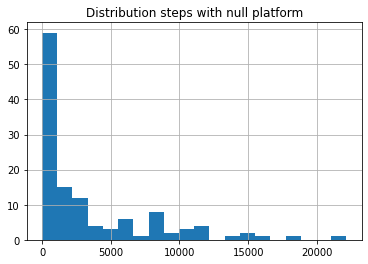

In [8]:
# make a plot for rows with null platform
plt.figure(figsize=(6,4))
plt.title('Distribution steps with null platform')
df.loc[df['platform'].isna()]['cnt_steps'].hist(bins = 20)
plt.show()

In [9]:
# overview
df.loc[df['platform'].isna()]['cnt_steps'].describe()

count      123.000000
mean      3265.878049
std       4596.785861
min          0.000000
25%          0.000000
50%       1610.000000
75%       4699.000000
max      22148.000000
Name: cnt_steps, dtype: float64

In [10]:
# perc of null data
null_value_cnt = len(df.loc[df['platform'].isna()])
print('Nan values', null_value_cnt)

nan_perc = round(null_value_cnt / len(df) * 100,2)
print('percent Nan values', nan_perc)

Nan values 123
percent Nan values 0.15


**The data contains less than 0.5% missing values, so these rows will be removed.Discussion questions: How might a user hide the device? What could be the reason for missing platform data?**

In [11]:
# delete null data
df = df.drop(df.loc[df['platform'].isna()].index)

### 1.3. Change types of columns

In [12]:
# change types for date columns
for i in df.columns:
    if i in ['steps_date', 'reg_date']:
        df[i] = pd.to_datetime(df[i])

In [13]:
# overview
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81426 entries, 0 to 81548
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     81426 non-null  int64         
 1   platform    81426 non-null  object        
 2   reg_date    81426 non-null  datetime64[ns]
 3   steps_date  81426 non-null  datetime64[ns]
 4   cnt_steps   81426 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 3.7+ MB


### 1.3. Find Duplicates

In [14]:
# check df for duplicated rows
df.duplicated().sum()

0

### 1.5. Find Outliers

In [15]:
# overview
df['cnt_steps'].describe()

count    81426.000000
mean      3934.520116
std       4826.883150
min          0.000000
25%        105.000000
50%       2189.000000
75%       6027.750000
max      60043.000000
Name: cnt_steps, dtype: float64

In [16]:
# check column cnt_steps to find outbursts
threshold_90 = np.percentile(df['cnt_steps'], 90)
threshold_95 = np.percentile(df['cnt_steps'], 95)
threshold_99 = np.percentile(df['cnt_steps'], 99)
print(f'for column cnt_steps thresholds of 90, 95 and 99 perc are, {threshold_90}, {threshold_95}, {threshold_99}')

for column cnt_steps thresholds of 90, 95 and 99 perc are, 10515.0, 13738.0, 20767.25


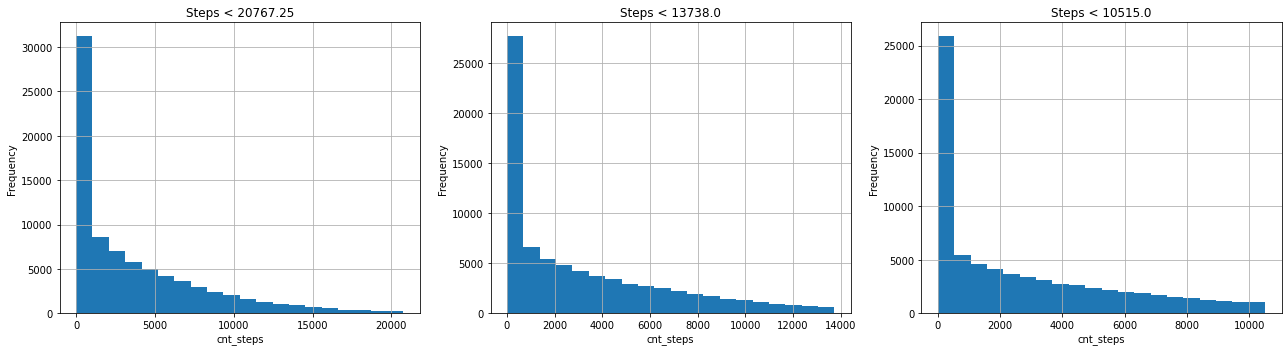

In [17]:
# Thresholds for filtering
threshold_list = [threshold_99, threshold_95, threshold_90]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot each histogram in its respective subplot
for idx, threshold in enumerate(threshold_list):
    ax = axes[idx]
    df[df['cnt_steps'] < threshold]['cnt_steps'].hist(bins=20, ax=ax)
    ax.set_title(f'Steps < {threshold}')
    ax.set_xlabel('cnt_steps')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [18]:
# how many users with 0 steps?
df.loc[df['cnt_steps'] == 0]['user_id'].nunique()

1339

In [19]:
# how many users with 0 steps via platform?
zero_steps_eda = (df.loc[df['cnt_steps'] == 0]
                        .groupby('platform')
                        .agg({'user_id' : 'nunique', 'cnt_steps' : 'count'})
                        .reset_index()
                        .rename(columns = {'user_id' : 'cnt_unique_users', 'cnt_steps' : 'cnt_rows'})
                )

zero_steps_eda

,platform,cnt_unique_users,cnt_rows
0,ANDROID,1337,18714
1,IOS,2,28


In [20]:
# how many users with 0 steps via platform (perc)?
round(zero_steps_eda['cnt_rows'].sum() / df['cnt_steps'].count() * 100, 2)

23.02

- Over 20% of the data has zero steps, that’s a significant amount.
- Discussion questions: How can the app record 0 steps (e.g., when a user opens the app without walking, or during complete inactivity)? What issues exist with step tracking? Why is this issue particularly relevant for Android?
- Since the dataset is large, we won’t delete these records for now, but we will keep this point in mind!

### Data Preprocessing. Conclusions:
1. Renamed columns for clarity
2. Removed unnecessary data
3. Dropped rows with missing platform information
4. Identified a high number of users with zero recorded steps
5. Highlighted key discussion questions

## 2. Exploratory Data Analysis

### 2.1. Count of unique users

In [21]:
len(df['user_id'].unique())

3526

### 2.2. Count of unique users via platforms 

In [22]:
# make a pivot to find the answer
platform_dist = (df
                    .groupby('platform')
                    .agg({'user_id':'nunique', 'platform':'count'})
                    .rename(columns = {'user_id' : 'cnt_unique_users', 'platform' : 'cnt_user_records'})
                    .reset_index()
                )

platform_dist['record_per_user'] = round(platform_dist['cnt_user_records'] / platform_dist['cnt_unique_users'],2)
platform_dist

,platform,cnt_unique_users,cnt_user_records,record_per_user
0,ANDROID,1393,34794,24.98
1,IOS,2133,46632,21.86


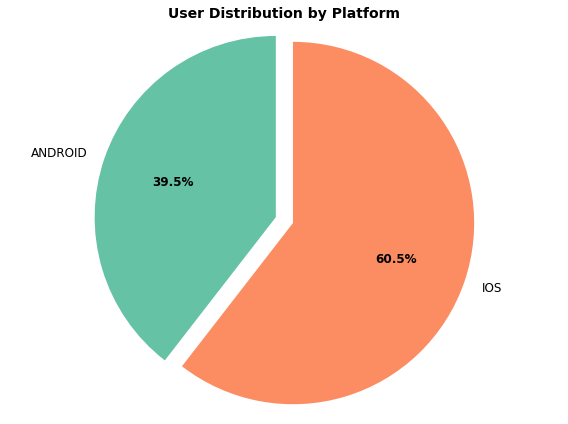

In [23]:
# Data
labels = platform_dist['platform']
sizes = platform_dist['cnt_unique_users']
explode = [0.05] * len(labels)  # Slightly "explode" all slices for effect
colors = plt.cm.Set2.colors  # Clean, colorful palette

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    colors=colors,
    textprops={'fontsize': 12, 'color': 'black'}
)

# Styling
ax.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.setp(autotexts, weight='bold')  # Make percentages bold
plt.title('User Distribution by Platform', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()


### 2.3. What period is the data for?

In [24]:
print('Minimum reg_date:', df['reg_date'].min(), 'Maximum reg_date:', df['reg_date'].max())
print('Minimum steps_date:', df['steps_date'].min(), 'Maximum steps_date:', df['steps_date'].max())

Minimum reg_date: 2021-01-15 00:00:00 Maximum reg_date: 2021-04-22 00:00:00
Minimum steps_date: 2021-01-01 00:00:00 Maximum steps_date: 2021-04-22 00:00:00


**Note on the data: the data covers winter and spring periods, so seasonality may be present.**

In [25]:
# check if there is more than 1 registration date for user?
more_than_one_reg = (df
                    .groupby('user_id')
                    .agg({'reg_date':'nunique'})
                    .reset_index()
                    .query("reg_date > 1")
                )

more_than_one_reg

,user_id,reg_date


In [26]:
# check if there is more than 1 date for unique days?
more_than_one_un_act = (df
                    .groupby('user_id')
                    .agg({'steps_date':'nunique', 'platform':'count'})
                    .rename(columns = {'steps_date' : 'cnt_unique_date_with_steps', 'platform' : 'cnt_date_with_steps'})
                    .reset_index()                    
                )

more_than_one_un_act.loc[(more_than_one_un_act['cnt_date_with_steps'] - more_than_one_un_act['cnt_unique_date_with_steps']) != 0]

,user_id,cnt_unique_date_with_steps,cnt_date_with_steps


### 2.4. How many days before & after registration do we have?

In [27]:
# pivot
days_bef_aft_reg = (df
                    .groupby(['user_id', 'reg_date'])
                    .agg({'steps_date':['min', 'max'], 'reg_date':'first'})
                )

# reset multi index
days_bef_aft_reg.columns = days_bef_aft_reg.columns.map('_'.join)
days_bef_aft_reg = days_bef_aft_reg.reset_index()

# add new columns
days_bef_aft_reg['days_before_reg'] = ((days_bef_aft_reg['reg_date'] - days_bef_aft_reg['steps_date_min']) / np.timedelta64(1, 'D')).astype(int)
days_bef_aft_reg['days_after_reg'] = ((days_bef_aft_reg['steps_date_max'] - days_bef_aft_reg['reg_date']) / np.timedelta64(1, 'D')).astype(int)
days_bef_aft_reg['reg_mark'] = days_bef_aft_reg['days_after_reg'].apply(lambda x: 'max_dt_before_reg' if int(x) < 0 else 'max_dt_is_reg_date' if int(x) == 0 else 'max_dt_after_reg')

# print
days_bef_aft_reg.head()

,user_id,reg_date,steps_date_min,steps_date_max,reg_date_first,days_before_reg,days_after_reg,reg_mark
0,16661153,2021-03-25,2021-03-11,2021-03-24,2021-03-25,14,-1,max_dt_before_reg
1,19161801,2021-02-26,2021-02-12,2021-03-11,2021-02-26,14,13,max_dt_after_reg
2,19761882,2021-01-15,2021-01-01,2021-01-16,2021-01-15,14,1,max_dt_after_reg
3,20395818,2021-01-24,2021-01-10,2021-01-28,2021-01-24,14,4,max_dt_after_reg
4,20702719,2021-01-16,2021-01-02,2021-01-29,2021-01-16,14,13,max_dt_after_reg


In [28]:
# pivot users with registration mark
(days_bef_aft_reg
        .groupby('reg_mark')
        .agg({'user_id' : 'nunique'})
        .reset_index()
        .rename(columns = {'user_id' : 'cnt_unique_users'})
)

,reg_mark,cnt_unique_users
0,max_dt_after_reg,2883
1,max_dt_before_reg,459
2,max_dt_is_reg_date,184


**For the purposes of the analysis, we need a user group whose maximum activity date is greeater than their registration date. Note: it is possible to use app without registration**

In [29]:
# join tables
df = df.merge(days_bef_aft_reg, on = ['user_id', 'reg_date'], how = 'left')

In [30]:
# select users with data after registration
final_df = df.loc[df['reg_mark'] == 'max_dt_after_reg']

In [31]:
# overview
final_df.head()

,user_id,platform,reg_date,steps_date,cnt_steps,steps_date_min,steps_date_max,reg_date_first,days_before_reg,days_after_reg,reg_mark
2,41494466,IOS,2021-03-28,2021-04-01,5635,2021-03-14,2021-04-10,2021-03-28,14,13,max_dt_after_reg
3,41583452,IOS,2021-04-02,2021-04-01,1840,2021-03-19,2021-04-15,2021-04-02,14,13,max_dt_after_reg
4,41637532,IOS,2021-04-07,2021-04-01,3127,2021-03-24,2021-04-08,2021-04-07,14,1,max_dt_after_reg
5,41578997,ANDROID,2021-04-01,2021-04-01,1603,2021-03-18,2021-04-09,2021-04-01,14,8,max_dt_after_reg
6,41574472,IOS,2021-04-01,2021-04-01,10697,2021-03-18,2021-04-14,2021-04-01,14,13,max_dt_after_reg


In [33]:
print('unique users after filtering data:', len(final_df['user_id'].unique()))

unique users after filtering data: 2883


### 2.5. Activity on work and weekend days

In [34]:
final_df = final_df.copy()

final_df['day_of_the_week'] = final_df['steps_date'].apply(lambda x: x.weekday())
final_df['is_weekend'] = final_df['day_of_the_week'].apply(lambda x: 'weekend_day' if x in [5, 6] else 'work_day')

final_df.head()

,user_id,platform,reg_date,steps_date,cnt_steps,steps_date_min,steps_date_max,reg_date_first,days_before_reg,days_after_reg,reg_mark,day_of_the_week,is_weekend
2,41494466,IOS,2021-03-28,2021-04-01,5635,2021-03-14,2021-04-10,2021-03-28,14,13,max_dt_after_reg,3,work_day
3,41583452,IOS,2021-04-02,2021-04-01,1840,2021-03-19,2021-04-15,2021-04-02,14,13,max_dt_after_reg,3,work_day
4,41637532,IOS,2021-04-07,2021-04-01,3127,2021-03-24,2021-04-08,2021-04-07,14,1,max_dt_after_reg,3,work_day
5,41578997,ANDROID,2021-04-01,2021-04-01,1603,2021-03-18,2021-04-09,2021-04-01,14,8,max_dt_after_reg,3,work_day
6,41574472,IOS,2021-04-01,2021-04-01,10697,2021-03-18,2021-04-14,2021-04-01,14,13,max_dt_after_reg,3,work_day


### Exploratory Data Analysis. Conclusions:
- Number of unique users at the start of EDA = 3,526
- Main platforms: iOS and Android, split approximately 60% to 40%
- Data spans from January to April 2021, so seasonality may be a factor
- Users whose maximum activity date is less than or equal to their registration date were identified and filtered
- Days of the week were extracted, and a weekend indicator was added

## 3. Compare two groups of users

### 3.1. Split dataset on two parts

In [35]:
# split
df_before_app = final_df.loc[final_df['steps_date'] < final_df['reg_date']]
df_after_app = final_df.loc[(final_df['steps_date'] > final_df['reg_date']) | (final_df['steps_date'] == final_df['reg_date'])]

In [36]:
# check frames 1
final_df.shape

(73074, 13)

In [37]:
# check frames 2
df_before_app.shape, df_after_app.shape

((39202, 13), (33872, 13))

In [38]:
# check count of users 1
len(final_df['user_id'].unique())

2883

In [39]:
# check count of users 
len(df_before_app['user_id'].unique()), len(df_after_app['user_id'].unique())

(2872, 2883)

In [40]:
# why? maybe steps_date_min == reg_date
len(df_after_app['user_id'].unique()) - len(df_before_app['user_id'].unique())

11

In [41]:
# find users with steps_date_min == reg_date
a = df_before_app['user_id'].unique()
b = df_after_app['user_id'].unique()

result = [item for item in b if item not in a]  
print('not crossing users', result, len(result))    

not crossing users [41319653, 41402549, 41182405, 41677710, 41611190, 40774769, 41676727, 41371984, 41286706, 40755819, 41376771] 11


In [42]:
# delete them
df_after_app = df_after_app.drop(df_after_app.loc[df_after_app['user_id'].isin(result)].index)

In [43]:
# overview
len(df_before_app['user_id'].unique()), len(df_after_app['user_id'].unique())

(2872, 2872)

**Previously a large number of users with zero steps was found. Let’s check if there are users whose maximum step count equals zero in both tables.**

In [44]:
# check the users with 0 steps before registration df_before_app
zero_steps_before = df_before_app.groupby('user_id').agg({'cnt_steps':'mean'}).reset_index().query('cnt_steps == 0')
zero_steps_before.shape

(1148, 2)

In [45]:
# list to delete
users_to_del = zero_steps_before['user_id'].unique()
users_to_del[:5]

array([19761882, 20702719, 24770769, 31877017, 40272343])

In [46]:
# check the users with 0 step before registration df_after_app
zero_steps_after = df_after_app.groupby('user_id').agg({'cnt_steps':'mean'}).reset_index().query('cnt_steps == 0')
zero_steps_after.shape

(7, 2)

In [47]:
# are these users crossed?
count = 0
for i in zero_steps_after['user_id']:
    if i in users_to_del:
        print('yes', i)
        count += 1
print('_______________')        
print('cnt', count)        

yes 40827793
yes 40905566
yes 41065548
yes 41143481
yes 41277102
yes 41283456
yes 41458874
_______________
cnt 7


In [48]:
# delete them
df_before_app = df_before_app.drop(df_before_app.loc[df_before_app['user_id'].isin(users_to_del)].index)
df_after_app = df_after_app.drop(df_after_app.loc[df_after_app['user_id'].isin(users_to_del)].index)

In [49]:
# overview
len(df_before_app['user_id'].unique()), len(df_after_app['user_id'].unique())

(1724, 1724)

In [50]:
# delete them
df_before_app.shape, df_after_app.shape

((23304, 13), (20145, 13))

- Removed users who had no data before registration
- Removed users who had only zero-step data before registration

### 3.2. Count Metrics for two groups

In [51]:
# avg steps before using app 
mean_steps_b = round(df_before_app['cnt_steps'].mean())
print(f'avg steps before using app {mean_steps_b}')

avg steps before using app 4818


In [52]:
# avg steps before using app via week days
weekly_steps_b = (df_before_app
                    .groupby(['day_of_the_week'])
                    .agg({'user_id' : 'nunique', 'cnt_steps' : 'mean'})
                    .reset_index()
                    .rename(columns = {'user_id' : 'cnt_users', 'cnt_steps' : 'cnt_steps_before'})
                )

round(weekly_steps_b)

,day_of_the_week,cnt_users,cnt_steps_before
0,0,1716,4930.0
1,1,1715,4946.0
2,2,1713,5075.0
3,3,1716,5119.0
4,4,1713,5067.0
5,5,1713,4774.0
6,6,1712,3808.0


In [53]:
# avg steps before using app via type of the day
weekend_steps_b = (df_before_app
                    .groupby(['is_weekend'])
                    .agg({'user_id' : 'nunique', 'cnt_steps' : 'mean'})
                    .reset_index()
                    .rename(columns = {'user_id' : 'cnt_users', 'cnt_steps' : 'cnt_steps_before'})
                )

round(weekend_steps_b)

,is_weekend,cnt_users,cnt_steps_before
0,weekend_day,1716,4293.0
1,work_day,1723,5027.0


In [54]:
# avg steps after using app 
mean_steps_af = round(df_after_app['cnt_steps'].mean())
print(f'avg steps after using app  {mean_steps_af}')

avg steps after using app  5369


In [55]:
# avg steps after using app via week days
weekly_steps_af = (df_after_app
                    .groupby(['day_of_the_week'])
                    .agg({'user_id' : 'nunique', 'cnt_steps' : 'mean'})
                    .reset_index()
                    .rename(columns = {'user_id' : 'cnt_users', 'cnt_steps' : 'cnt_steps_after'})
                )

round(weekly_steps_af)

,day_of_the_week,cnt_users,cnt_steps_after
0,0,1611,5357.0
1,1,1626,5665.0
2,2,1622,5717.0
3,3,1578,5696.0
4,4,1559,5650.0
5,5,1559,5194.0
6,6,1585,4301.0


In [56]:
# avg steps after using app via type of the day
weekend_steps_af = (df_after_app
                    .groupby(['is_weekend'])
                    .agg({'user_id' : 'nunique', 'cnt_steps' : 'mean'})
                    .reset_index()
                    .rename(columns = {'user_id' : 'cnt_users', 'cnt_steps' : 'cnt_steps_after'})
                )

round(weekend_steps_af)

,is_weekend,cnt_users,cnt_steps_after
0,weekend_day,1610,4744.0
1,work_day,1715,5617.0


### 3.2. Compare two groups

In [57]:
# perc of growth
round((1 - mean_steps_b / mean_steps_af) * 100)

10

In [58]:
# via weekdays
compare_weekly_df = weekly_steps_b.merge(weekly_steps_af[['day_of_the_week', 'cnt_steps_after']], on = 'day_of_the_week', how = 'inner')
compare_weekly_df['growth_perc'] = round((1 - (compare_weekly_df['cnt_steps_before'] / compare_weekly_df['cnt_steps_after'])) * 100,2)
round(compare_weekly_df,2)

,day_of_the_week,cnt_users,cnt_steps_before,cnt_steps_after,growth_perc
0,0,1716,4930.37,5357.30,7.97
1,1,1715,4945.81,5665.47,12.70
2,2,1713,5075.00,5716.77,11.23
3,3,1716,5119.39,5696.09,10.12
4,4,1713,5066.59,5650.12,10.33
5,5,1713,4773.89,5193.76,8.08
6,6,1712,3808.47,4300.94,11.45


In [59]:
# via type of the day
compare_weekend_df = weekend_steps_b.merge(weekend_steps_af[['is_weekend', 'cnt_steps_after']], on = 'is_weekend', how = 'inner')
compare_weekend_df['growth_perc'] = round((1 - (compare_weekend_df['cnt_steps_before'] / compare_weekend_df['cnt_steps_after'])) * 100,2)
round(compare_weekend_df,2)

,is_weekend,cnt_users,cnt_steps_before,cnt_steps_after,growth_perc
0,weekend_day,1716,4292.63,4743.75,9.51
1,work_day,1723,5027.46,5616.76,10.49


### 3.3. Make Plots

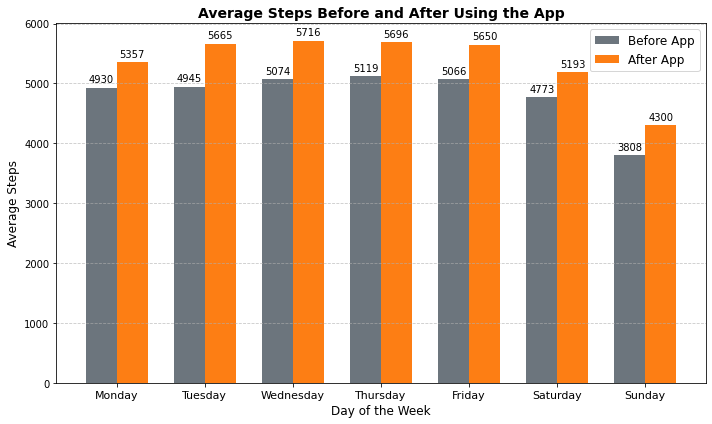

In [60]:
fig, ax = plt.subplots(figsize=(10, 6))

data1 = weekly_steps_b['cnt_steps_before']
data2 = weekly_steps_af['cnt_steps_after']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

width = 0.35
x = np.arange(len(days))

bars1 = ax.bar(x - width/2, data1, width, label='Before App', color='#6c757d')  # muted grey
bars2 = ax.bar(x + width/2, data2, width, label='After App', color='#fd7e14')   # vibrant orange

# Labels and title
ax.set_ylabel('Average Steps', fontsize=12)
ax.set_xlabel('Day of the Week', fontsize=12)
ax.set_title('Average Steps Before and After Using the App', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(days, fontsize=11)
ax.legend(fontsize=12)

# Add gridlines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset label position
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, color='black')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


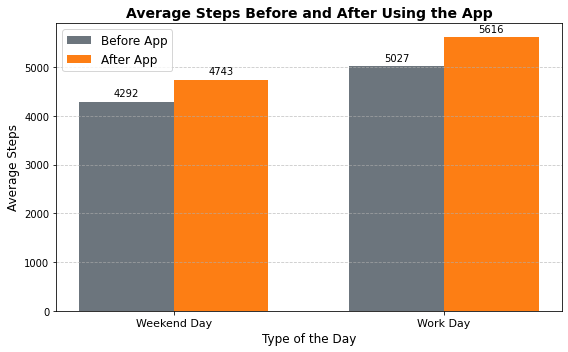

In [61]:
fig, ax = plt.subplots(figsize=(8, 5))

data1 = weekend_steps_b['cnt_steps_before']
data2 = weekend_steps_af['cnt_steps_after']
day_types = ['Weekend Day', 'Work Day']

width = 0.35
x = np.arange(len(day_types))

bars1 = ax.bar(x - width/2, data1, width, label='Before App', color='#6c757d')  # muted grey
bars2 = ax.bar(x + width/2, data2, width, label='After App', color='#fd7e14')   # vibrant orange

# Labels and title
ax.set_ylabel('Average Steps', fontsize=12)
ax.set_xlabel('Type of the Day', fontsize=12)
ax.set_title('Average Steps Before and After Using the App', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(day_types, fontsize=11)
ax.legend(fontsize=12)

# Add gridlines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, color='black')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


### 3.4. Check statistical significance

In [62]:
# avg steps per users
t1 = df_before_app.groupby('user_id').agg({'cnt_steps':'mean'}).reset_index().rename(columns = {'cnt_steps' : 'avg_steps_before'})
t2 = df_after_app.groupby('user_id').agg({'cnt_steps':'mean'}).reset_index().rename(columns = {'cnt_steps' : 'avg_steps_after'})

df_compare = t1.merge(t2, how = 'inner', on = 'user_id')
df_compare.head()

,user_id,avg_steps_before,avg_steps_after
0,19161801,3049.571429,6986.428571
1,20395818,1025.928571,456.600000
2,39957739,870.500000,1066.000000
3,40549741,5160.857143,7683.000000
4,40572583,3126.307692,2736.214286


In [63]:
df_compare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1724 entries, 0 to 1723
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           1724 non-null   int64  
 1   avg_steps_before  1724 non-null   float64
 2   avg_steps_after   1724 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 40.5 KB


In [64]:
# Calculate difference
diff = df_compare['avg_steps_after'] - df_compare['avg_steps_before']

# Shapiro-Wilk test for normality
stat, p = shapiro(diff)

# Print result
print(f'Shapiro-Wilk test statistic = {stat:.4f}, p-value = {p:.4f}')
if p > 0.05:
    print("The distribution of differences is likely normal (p > 0.05). You can use a paired t-test.")
else:
    print("The distribution of differences is likely NOT normal (p ≤ 0.05). Consider using a non-parametric test, like the Wilcoxon signed-rank test.")


Shapiro-Wilk test statistic = 0.9225, p-value = 0.0000
The distribution of differences is likely NOT normal (p ≤ 0.05). Consider using a non-parametric test, like the Wilcoxon signed-rank test.


In [65]:
# Calculate means
mean_before = df_compare['avg_steps_before'].mean()
mean_after = df_compare['avg_steps_after'].mean()

print(f"Average steps before app: {mean_before:.2f}")
print(f"Average steps after app:  {mean_after:.2f}\n")

# Wilcoxon signed-rank test
stat, p = wilcoxon(df_compare['avg_steps_before'], df_compare['avg_steps_after'])

print(f'Wilcoxon signed-rank test statistic = {stat:.4f}, p-value = {p:.4f}')

if p < 0.05:
    print("✅ Statistically significant difference between 'before' and 'after' (p < 0.05).")
else:
    print("ℹ️ No statistically significant difference found (p ≥ 0.05).")


Average steps before app: 4774.82
Average steps after app:  5282.60

Wilcoxon signed-rank test statistic = 560431.0000, p-value = 0.0000
✅ Statistically significant difference between 'before' and 'after' (p < 0.05).


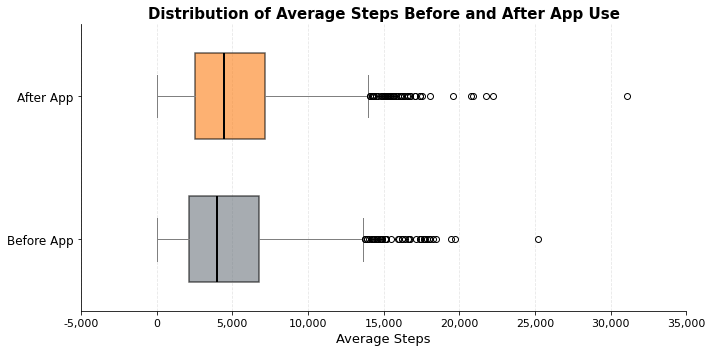

In [66]:
# Prepare the data
data = [df_compare['avg_steps_before'], df_compare['avg_steps_after']]
labels = ['Before App', 'After App']
colors = ['#6c757d', '#fd7e14']  # Grey and orange

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))
box = ax.boxplot(data, patch_artist=True, vert=False, tick_labels=labels, widths=0.6)


# Style the boxes
for i, patch in enumerate(box['boxes']):
    patch.set_facecolor(colors[i])
    patch.set_edgecolor('black')
    patch.set_alpha(0.6)
    patch.set_linewidth(1.5)

# Style the medians
for median in box['medians']:
    median.set_color('black')
    median.set_linewidth(2)

# Style the whiskers and caps
for whisker in box['whiskers']:
    whisker.set_color('gray')
    whisker.set_linewidth(1)

for cap in box['caps']:
    cap.set_color('gray')
    cap.set_linewidth(1)

# Title and labels
ax.set_title('Distribution of Average Steps Before and After App Use', fontsize=15, fontweight='bold')
ax.set_xlabel('Average Steps', fontsize=13)
ax.set_yticklabels(labels, fontsize=12)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([f'{int(tick):,}' for tick in ax.get_xticks()], fontsize=11)

# Grid styling
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


### 3.5. Check Growth & Recession

In [67]:
# Bins and labels must match: len(labels) == len(bins) + 1
growth_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
growth_labels = [
    '0% - 10%', '10% - 20%', '20% - 30%', '30% - 40%', '40% - 50%',
    '50% - 60%', '60% - 70%', '70% - 80%', '80% - 90%', '90% - 100%',
    '100% - 200%', '200% +'
]

decline_bins = [-200, -100, -90, -80, -70, -60, -50, -40, -30, -20, -10]
decline_labels = [
    '200% -', '100% - 200%', '90% - 100%', '80% - 90%', '70% - 80%',
    '60% - 70%', '50% - 60%', '40% - 50%', '30% - 40%', '20% - 30%',
    '10% - 20%', '0% - 10%'
]

# Unified categorization function
def percent_cluster(x):
    if x >= 0:
        idx = bisect.bisect_right(growth_bins, x)
        return growth_labels[idx]
    else:
        idx = bisect.bisect_right(decline_bins, x)
        return decline_labels[idx]

# Calculations
df_compare['diff_abs'] = df_compare['avg_steps_after'] - df_compare['avg_steps_before']
df_compare['diff_perc'] = (df_compare['diff_abs'] / df_compare['avg_steps_before'] * 100).fillna(0)

df_compare['growth_mark'] = (df_compare['diff_perc'] >= 0).astype(int)
df_compare['growth_perc'] = df_compare['diff_perc'].apply(percent_cluster)

# Group and aggregate
growth_clusters = (
    df_compare.query('growth_mark == 1')
              .groupby('growth_perc', as_index=False)['user_id']
              .count()
              .rename(columns={'user_id': 'cnt_users'})
              .sort_values('growth_perc', ascending=True)
)

growth_clusters


,growth_perc,cnt_users
0,0% - 10%,191
1,10% - 20%,160
2,100% - 200%,115
3,20% - 30%,123
4,200% +,112
5,30% - 40%,85
6,40% - 50%,58
7,50% - 60%,54
8,60% - 70%,33
9,70% - 80%,39


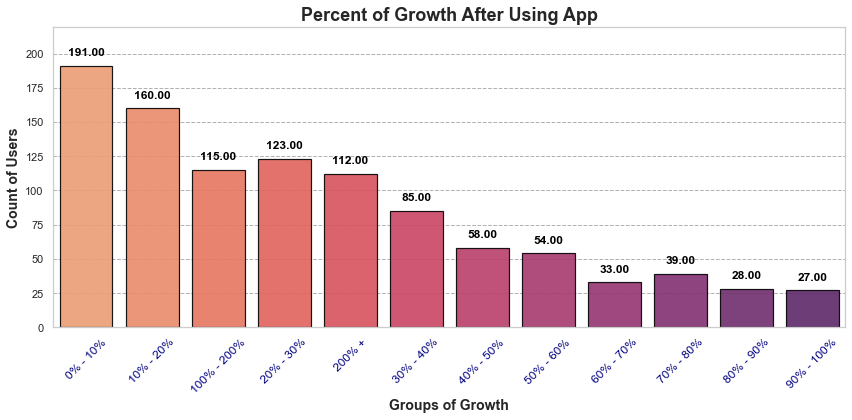

In [68]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Define a color palette with the same length as your data
palette = sns.color_palette("flare", len(growth_clusters))

plots = sns.barplot(
    x="growth_perc",
    y="cnt_users",
    data=growth_clusters,
    color='orange',  # temporary, will overwrite colors below
    edgecolor='black'
)

# Assign colors manually to each bar to avoid the warning
for bar, color in zip(plots.patches, palette):
    bar.set_facecolor(color)
    bar.set_edgecolor('black')
    bar.set_linewidth(1.2)
    bar.set_alpha(0.9)

# Annotate bars
for bar in plots.patches:
    height = bar.get_height()
    plots.annotate(
        f'{height:.2f}',
        (bar.get_x() + bar.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        xytext=(0, 8),
        textcoords='offset points',
        color='black'
    )

plt.xlabel("Groups of Growth", fontsize=14, fontweight='semibold')
plt.ylabel("Count of Users", fontsize=14, fontweight='semibold')
plt.title("Percent of Growth After Using App", fontsize=18, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, color='navy')
plots.yaxis.grid(True, color='gray', linestyle='--', alpha=0.6)
plots.xaxis.grid(False)
plt.ylim(0, max(growth_clusters['cnt_users']) * 1.15)
plt.tight_layout()
plt.show()


In [69]:
# pivot recession clusters
recession_clusters = (df_compare
                    .query('growth_mark == 0')
                    .groupby('growth_perc')
                    .agg({'user_id':'count'})
                    .reset_index()
                    .rename(columns = {'user_id' : 'cnt_users'})
                    .sort_values(by = 'cnt_users', ascending = False)
                     )
recession_clusters

,growth_perc,cnt_users
0,0% - 10%,170
1,10% - 20%,168
2,20% - 30%,133
3,30% - 40%,88
4,40% - 50%,57
5,50% - 60%,36
6,60% - 70%,23
7,70% - 80%,16
8,80% - 90%,6
9,90% - 100%,2


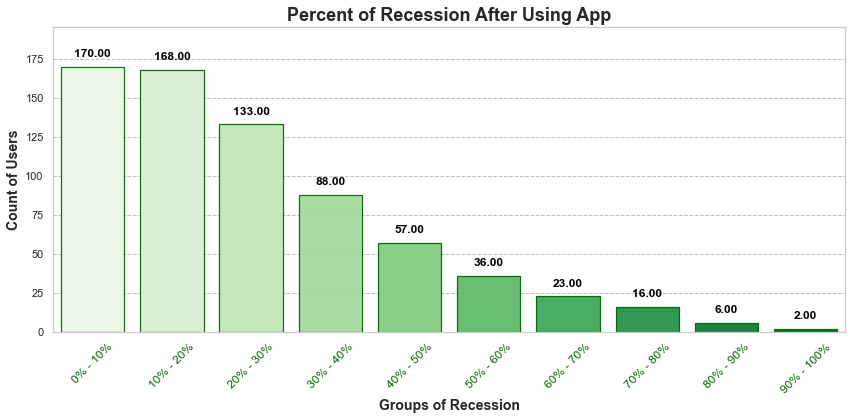

In [70]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Green color palette for bars
palette = sns.color_palette("Greens", len(recession_clusters))

plots = sns.barplot(
    x="growth_perc",
    y="cnt_users",
    data=recession_clusters,
    color='green',  # placeholder, will override colors below
    edgecolor='darkgreen'
)

# Assign each bar a shade of green from the palette
for bar, color in zip(plots.patches, palette):
    bar.set_facecolor(color)
    bar.set_edgecolor('darkgreen')
    bar.set_linewidth(1.2)
    bar.set_alpha(0.95)

# Annotate bars with count values, above bars
for bar in plots.patches:
    height = bar.get_height()
    plots.annotate(
        f'{height:.2f}',
        (bar.get_x() + bar.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        xytext=(0, 8),
        textcoords='offset points',
        color='black'
    )

plt.xlabel("Groups of Recession", fontsize=14, fontweight='semibold')
plt.ylabel("Count of Users", fontsize=14, fontweight='semibold')
plt.title("Percent of Recession After Using App", fontsize=18, fontweight='bold')

plt.xticks(rotation=45, fontsize=12, color='darkgreen')
plots.yaxis.grid(True, color='gray', linestyle='--', alpha=0.5)
plots.xaxis.grid(False)

plt.ylim(0, max(recession_clusters['cnt_users']) * 1.15)
plt.tight_layout()
plt.show()


In [71]:
# percentage of growth and recession
cnt_growth = growth_clusters['cnt_users'].sum()
cnt_recession = recession_clusters['cnt_users'].sum()
total = cnt_growth + cnt_recession

print(f'Percentage of users who experienced metric growth: {round(cnt_growth / total * 100, 2)}%')
print(f'Percentage of users who experienced metric decline: {round(cnt_recession / total * 100, 2)}%')


Percentage of users who experienced metric growth: 59.45%
Percentage of users who experienced metric decline: 40.55%


### Compare two groups of users. Conclusions:
- The final table is divided into 2 groups: data before app installation and data after app installation.  
- Some users were excluded:  
  - Those whose minimum step date equals their registration date.  
  - Those whose maximum number of steps is zero.  
- Metrics were calculated for both groups:  
  - Average number of steps by day of the week.  
  - Average number of steps by day type (weekend or weekday).  
  - Average number of steps per user before and after app installation.  
- The average number of steps increased by 10% for users after installing the app.  
- Statistical significance tests were performed to validate the results.  
- Groups of users who showed growth in steps before and after using the app were analyzed (59% of users).  
  - In both groups, the leaders were users with growth/decline of 10%, 20%, and 30% respectively compared to the rest.  
- Groups of users who showed a decline in steps after using the app were analyzed (41% of users).  
  - Most declines ranged between 10% and 30%.  
- Number of users with increased steps = (%), number of users with decreased steps = (%).


## 4. Results, Conclusions and Recommendations

### Results:
An analysis of user data was conducted for the period January - April 2021. The main goal of the analysis was to answer the question: *“How did using the app affect the number of steps taken by users?”*

The analysis consisted of 4 main stages:  
1. Data preprocessing  
2. Data exploration  
3. Calculation and comparison of metrics by groups  
4. Conclusions  

- In the first stage, naming conventions were standardized, unnecessary data was removed, and key questions for discussion were defined.  
- In the second stage, the number of unique users, main platforms, and data coverage period were identified; users were divided into groups based on the relationship between registration date and user’s max date; weekday and day type (weekend/weekday) features were added.  
- In the third stage, the dataset was split into two subsets, key metrics were compared between groups, and the impact of app usage on average step count was evaluated.  
- In the fourth stage, conclusions were drawn.  

### Conclusions:
1. Using the app positively affected the average number of steps taken by users, increasing the metric by 10%.  
2. On weekdays, users walk more on average than on weekends.  
3. Some users decreased their activity after starting to use the app.  
4. The largest increases/decreases in average step counts were by 10%, 20%, and 30%, respectively.  

### Recommendations:
1. Since the analysis was performed during the winter-spring period, it is advisable to additionally check for seasonality effects in the second half of the year.  
2. Investigate the long-term effect of app usage (from 60 days up to a year), as initial results can sometimes be influenced by novelty effects.  
3. Discuss questions about the data that arose during the analysis process.
